In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(11)
sns.set()
%matplotlib inline

# Introduction
In this notebook, I'll be be using a database of credit card transactions to build an accurate predictor of whether a transaction is fraudulent.  The dataset, downloaded from Kaggle, is described in detail below.

Thinkful's instructions: "Using this credit card fraud dataset develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions."  In light of this, my best metric will be the F1-score, since it doesn't take the number of true negatives into account (whereas an evenly balanced metric like the Matthews Coefficient does).


# About the data

From Kaggle:

"The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

"It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."

It's particularly noteworthy that the dataset does not include an identity feature (so that pattern analysis could be personalized to each user).  The source does not specify whether this was included in the raw data (before PCA) or whether a version of PCA was used that could include a categorical variable of that nature.

# Methods

To begin with, I'll try a few general classifiers out of the box: logistic regression, random forest, and gradient boost.  Then I'll try adding the results of a couple anomaly detection algorithms as features.  Finally, I'll take the most promising model and optimize it over the complete dataset (including the anomaly flags.)

Because the data is already a aset of Principal Components (except for Amount and Time), there's no real opportunity for feature engineering, so my experimentations here will all be algorithmic.

# Load and examine

In [2]:
credit_df = pd.read_csv("practice/creditcard.csv")

In [3]:
print(credit_df.shape)
credit_df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
credit_df.isnull().sum().sum()

0

Mean transaction amount (Euros):  88.35
Median transaction amount (Euros):  22.0


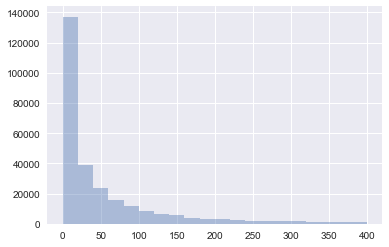

In [47]:
print("Mean transaction amount (Euros): ", round(credit_df.Amount.mean(), 2))
print("Median transaction amount (Euros): ", credit_df.Amount.median())
x = [amt for amt in credit_df.Amount if amt < 400]
sns.distplot(x, bins=20, kde=False)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
X = credit_df.drop('Class', axis=1)
y = credit_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Initial model trials

## Model 1: logistic regression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lreg = LogisticRegression(penalty='l2')
lreg.fit(X_train, y_train)
train_pred = lreg.predict(X_train)
test_pred = lreg.predict(X_test)

false_neg = sum((y_test - test_pred) == 1)
false_pos = sum((y_test - test_pred) == -1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)

Train score:  0.656
Test score:  0.709
False negatives:  40
False positives:  28


## Model 2: Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from time import time
start = time()

rfc = RandomForestClassifier(n_estimators=20)
rfc.fit(X_train, y_train)
train_pred = rfc.predict(X_train)
test_pred = rfc.predict(X_test)

false_neg = sum((y_test - test_pred) == 1)
false_pos = sum((y_test - test_pred) == -1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.992
Test score:  0.856
False negatives:  25
False positives:  8
Elapsed time (s):  39.06005573272705


## Model 3: Gradient Boosted Tree

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
start = time()

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
train_pred = gbc.predict(X_train)
test_pred = gbc.predict(X_test)

false_pos = sum((y_test - test_pred) == -1)
false_neg = sum((y_test - test_pred) == 1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.649
Test score:  0.648
False negatives:  55
False positives:  19
Elapsed time (s):  155.08902025222778


## Model 4: Isolation Forest

In [10]:
from sklearn.ensemble import IsolationForest
start = time()
fraud_ratio = y_train.sum()/len(y_train)
iso = IsolationForest(contamination=fraud_ratio*2) # multiplied by 2 to make this more inclusive (catching false negs)
iso.fit(X_train, y_train)
train_pred = iso.predict(X_train)
test_pred = iso.predict(X_test)

# convert +1/-1 output to 0/1:
train_pred = (1-train_pred)/2
test_pred = (1-test_pred)/2

false_pos = sum((y_test - test_pred) == -1)
false_neg = sum((y_test - test_pred) == 1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.255
Test score:  0.311
False negatives:  67
False positives:  181
Elapsed time (s):  23.06566023826599


Note: I tried running a hyperparameter sweep on this in hopes that the parameters were the problem.  Oddly, it won't run.  (Error reports included after the Conclusion near bottom of notebook.)  Manual tweaking turned up some small increases, but even dramatic decreases didn't seem to make any difference for the amount of help provided to Random Forest.

The goal of Isolation Forest in this context is not to itself attain high accuracy, but to add a useful feature (the anomaly flag) to our dataset.  Now let's try Random Forest again with this anomaly flag included and see how it affects our results.

In [11]:
# make version of X_train and X_test with anomaly flag included
X_train_a = X_train.copy()
X_train_a['isonomaly'] = pd.Series(train_pred).values
X_test_a = X_test.copy()
X_test_a['isonomaly'] = pd.Series(test_pred).values

In [12]:
start = time()
rfc = RandomForestClassifier(n_estimators=20)
rfc.fit(X_train_a, y_train)
train_pred = rfc.predict(X_train_a)
test_pred = rfc.predict(X_test_a)

false_neg = sum((y_test - test_pred) == 1)
false_pos = sum((y_test - test_pred) == -1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.986
Test score:  0.874
False negatives:  22
False positives:  7
Elapsed time (s):  37.21060299873352


It looks like our score shows only a small improvement with the addition of the Isolation Forest data.  (Our original accuracy for the out-of-box random forest was 0.856.)  Let's try one more anomaly detection algorithm: the Local Outlier Factor.

## Model 5: Local Outlier Factor

In [13]:
from sklearn.neighbors import LocalOutlierFactor
start = time()
lof = LocalOutlierFactor(contamination=fraud_ratio)
pred = lof.fit_predict(X)

# convert +1/-1 output to 1/0:
pred = (1-pred)/2

print("Score: ", round(f1_score(y, pred), 3))
print('Elapsed time (s): ', time()-start)

Score:  0.051
Elapsed time (s):  205.15208101272583


In [14]:
false_neg = sum((y - pred) == 1)
false_pos = sum((y - pred) == -1)
print("Score: ", round(f1_score(y, pred), 3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)

Xcore:  0.051
False negatives:  467
False positives:  467


In [15]:
X2 = X.copy()
X2['LOFlier'] = pd.Series(pred).values
X_traino, X_testo, y_traino, y_testo = train_test_split(X2, y, test_size = 0.25) # the 'o' is for outlier

In [16]:
start = time()
rfc = RandomForestClassifier(n_estimators=20)
rfc.fit(X_traino, y_traino)
train_pred = rfc.predict(X_traino)
test_pred = rfc.predict(X_testo)

false_neg = sum((y_test - test_pred) == 1)
false_pos = sum((y_test - test_pred) == -1)
print("Train score: ", round(f1_score(y_traino, train_pred), 3))
print("Test score: ", round(f1_score(y_testo, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.984
Test score:  0.837
False negatives:  123
False positives:  105
Elapsed time (s):  36.075578689575195


This actually scored lower than our out-of-box version, but it's a new split - unfortunately, it's impossible to run the LOF algorithm post-split.  And this score is within the range that results from different splits; the out-of-box RF score has varied from 0.825 to 0.856 with different splits.  So all that's clear is that the LOF flag addition helps very little if it helps at all.

# Model choice conclusions

Random Forest performed well here.  Boosted Tree didn't perform well on this split, but it performed just as well as Random Forest on one previous split (0.20 better, which is strange). While the anomaly detection / outlier detection algorithms didn't directly capture the frauds very accurately (f1-scores of 0.26 and 0.05), they did contribute (ableit very slightly) to the accuracy of our other models when used as features.

Moving forward, I'll try optimizing both Random Forest and Boosted Tree, and I'll include both our anomaly flags in the dataset.

# Optimizations

Because Local Outlier Factor needs to be run on the entire dataset pre-split, we'll take the LOF splits above and use those as our regular training data.  This means we'll also need to rerun Isolation Forest to re-generate the isonomaly feature.

In [17]:
start = time()
fraud_ratio = y_traino.sum()/len(y_traino)
iso = IsolationForest(n_estimators=100)
iso.fit(X_traino.drop('LOFlier', axis=1), y_traino)
train_pred = iso.predict(X_traino.drop('LOFlier', axis=1))
test_pred = iso.predict(X_testo.drop('LOFlier', axis=1))

# convert +1/-1 output to 0/1:
train_pred = (1-train_pred)/2
test_pred = (1-test_pred)/2

false_pos = sum((y_test - test_pred) == -1)
false_neg = sum((y_test - test_pred) == 1)
print("Train score: ", round(f1_score(y_traino, train_pred), 3))
print("Test score: ", round(f1_score(y_testo, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.031
Test score:  0.029
False negatives:  109
False positives:  7192
Elapsed time (s):  23.41415309906006


## Random Forest

First, let's run a hyperparameter sweep and see what we get.

In [18]:
# report utility function from http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [55]:
from sklearn.model_selection import RandomizedSearchCV

rfc_2 = RandomForestClassifier()

param_dist = {"n_estimators":[20, 30],
              "random_state":[11],
              "max_depth": [4,8,20],
              "max_features": [6,9,12,20],
              "min_samples_split": [2,10,20],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]
}

random_search = RandomizedSearchCV(rfc_2, param_distributions=param_dist, n_iter=20, cv=4, scoring='f1')
start = time()
random_search.fit(X_traino, y_traino)

print("Elapsed seconds: ", time()-start)
report(random_search.cv_results_, n_top=3)

Elapsed seconds:  4084.3675079345703
Model with rank: 1
Mean validation score: 0.873 (std: 0.026)
Parameters: {'random_state': 11, 'n_estimators': 30, 'min_samples_split': 20, 'max_features': 20, 'max_depth': 8, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.871 (std: 0.020)
Parameters: {'random_state': 11, 'n_estimators': 20, 'min_samples_split': 10, 'max_features': 6, 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.865 (std: 0.025)
Parameters: {'random_state': 11, 'n_estimators': 30, 'min_samples_split': 2, 'max_features': 9, 'max_depth': 20, 'criterion': 'gini', 'bootstrap': False}



It looks like we have several equally good scores that are all somewhat overfit.  Let's take these general parameters and look at our test score, false negatives, and false positives.

In [57]:
start = time()

params = {'random_state': 11, 'n_estimators': 30, 'min_samples_split': 20, 'max_features': 20, 'max_depth': 8, 'criterion': 'entropy', 'bootstrap': False}

rfc_opt = RandomForestClassifier(**params)
rfc_opt.fit(X_traino, y_traino)
train_pred = rfc_opt.predict(X_traino)
test_pred = rfc_opt.predict(X_testo)

false_pos = sum((y_testo - test_pred) == -1)
false_neg = sum((y_testo - test_pred) == 1)
print("Train score: ", round(f1_score(y_traino, train_pred), 3))
print("Test score: ", round(f1_score(y_testo, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.925
Test score:  0.829
False negatives:  25
False positives:  15
Elapsed time (s):  206.94753098487854


The good news here is that our f1-score is pretty solid at 0.88.  The bad news is that we still have 22 false negatives (out of 129 actual negatives), which means we're misidentifying 17% of fraudulent transactions.  Given the cost of failing to identify fraudulent transactions, identifying 83% of frauds probably isn't good enough.

We may be able to improve on this by changing our algorithm.  By adjusting the class weights of the random tree, we can heavily prioritize correctly identifying positive cases (the minority case) over negative cases.  Let's try over-weighting fraud identification by increasing powers of 10 and see what happens to our false negatives and our f1-scores.

In [21]:
start = time()
scores = []
false_neg_counts = []
false_pos_counts = []
balance_exps = [0, 2, 4, 6, 8, 10, 12]
for balance_exp in balance_exps:
    params = {'random_state': 11, 
              'n_estimators': 20, 
              'min_samples_split': 20, 
              'max_features': 20, 
              'max_depth': 8, 
              'criterion': 'entropy', 
              'bootstrap': False,
              'class_weight': {0:1, 1:10**balance_exp}
             }

    rfc = RandomForestClassifier(**params)
    rfc.fit(X_traino, y_traino)
    train_pred = rfc.predict(X_traino)
    test_pred = rfc.predict(X_testo)

    false_neg_counts.append( sum((y_testo - test_pred) == 1) )
    false_pos_counts.append( sum((y_testo - test_pred) == -1) )
    scores.append( round(f1_score(y_traino, train_pred), 3) )

print('Elapsed time (s): ', time()-start)

Elapsed time (s):  404.0913248062134


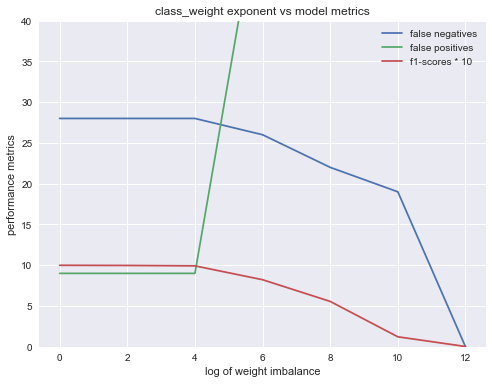

In [22]:
plt.figure(figsize=(8,6))
plt.plot(balance_exps, false_neg_counts, label='false negatives')
plt.plot(balance_exps, false_pos_counts, label='false positives')
plt.plot(balance_exps, [s*10 for s in scores], label='f1-scores * 10')
plt.title("class_weight exponent vs model metrics")
plt.xlabel('log of weight imbalance')
plt.ylabel('performance metrics')
plt.legend()
plt.ylim(0,40)
plt.show()

It looks like the tradeoff in accuracy is way too steep here: our f1-score drops below 0.5 before we see any significant reduction in false negatives.

For now, then, our best try is 83% fraud detection with an f1-score of 89%.  Let's table that for now and try optimizing our gradient boosted tree model.

# Optimizing Gradient Boosted Tree

We'll start by optimizing all parameters except the computation-intensive n_estimators and learning_rate, then hold the others constant while we tweak those two.

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from time import time

gbc_2 = GradientBoostingClassifier()

param_dist = {
    'loss': ['deviance','exponential'],
    'n_estimators': [50], # we'll change this next time
    'learning_rate': [0.1], # ditto
    'max_depth': [2,4,6,8],
    'max_features': [2,4,6,8],
    'subsample': [0.1, 0.3, 0.6, 1],
    'random_state': [11]
}

random_search = RandomizedSearchCV(gbc_2, param_distributions=param_dist, n_iter=25, scoring='f1', cv=4)
start = time()
random_search.fit(X_traino, y_traino)

print("Elapsed seconds: ", time()-start)
report(random_search.cv_results_, n_top=3)

Elapsed seconds:  800.3299012184143
Model with rank: 1
Mean validation score: 0.804 (std: 0.036)
Parameters: {'subsample': 0.6, 'random_state': 11, 'n_estimators': 50, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.1}

Model with rank: 2
Mean validation score: 0.801 (std: 0.028)
Parameters: {'subsample': 0.6, 'random_state': 11, 'n_estimators': 50, 'max_features': 6, 'max_depth': 4, 'loss': 'exponential', 'learning_rate': 0.1}

Model with rank: 3
Mean validation score: 0.796 (std: 0.030)
Parameters: {'subsample': 1, 'random_state': 11, 'n_estimators': 50, 'max_features': 4, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.1}



Note: I ran the above search with the default cv=3, which is why the scores are a little lower.  It doesn't change the ranking, which is what we're concerned about here, so I'm using the results as they are.

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
param_dist = {
    'loss': ['exponential'],
    'n_estimators': range(50, 200, 10),
    'learning_rate': np.arange(0.05, 0.2, 0.01),
    'max_depth': [6],
    'max_features': [6],
    'subsample': [0.6],
    'random_state': [11]
}

random_search = RandomizedSearchCV(gbc_2, param_distributions=param_dist, n_iter=10, scoring='f1', cv=4)
start = time()
random_search.fit(X_traino, y_traino)

print("Elapsed seconds: ", time()-start)
report(random_search.cv_results_, n_top=3)

Elapsed seconds:  1937.0215361118317
Model with rank: 1
Mean validation score: 0.872 (std: 0.023)
Parameters: {'subsample': 0.6, 'random_state': 11, 'n_estimators': 130, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.18000000000000005}

Model with rank: 2
Mean validation score: 0.872 (std: 0.027)
Parameters: {'subsample': 0.6, 'random_state': 11, 'n_estimators': 110, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.18000000000000005}

Model with rank: 3
Mean validation score: 0.867 (std: 0.023)
Parameters: {'subsample': 0.6, 'random_state': 11, 'n_estimators': 130, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.16000000000000003}



In [54]:
start = time()
params = {'random_state': 11, 'subsample': 0.6, 'n_estimators': 130, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.18}

gbc_3 = GradientBoostingClassifier(**params)
gbc_3.fit(X_traino, y_traino)
train_pred = gbc_3.predict(X_traino)
test_pred = gbc_3.predict(X_testo)

false_pos = sum((y_testo - test_pred) == -1)
false_neg = sum((y_testo - test_pred) == 1)
print("Train score: ", round(f1_score(y_traino, train_pred), 3))
print("Test score: ", round(f1_score(y_testo, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.971
Test score:  0.85
False negatives:  26
False positives:  8
Elapsed time (s):  99.17459917068481


We can see that gradient boosted tree will yield basically the same results as random forest.  For now, we'll use gradient boosted tree as our top performer moving forward.  But they're basically identical.

## Final boosted tree test

Our best model on our test set has been our gradient boosted tree.  Let's make sure this replicates across different random splits of our data (i.e., make sure it's not overfit to our test set).

In [26]:
start = time()

false_neg_counts = []
false_pos_counts = []
scores = []

for i in range(4):
    random.seed(a=i)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25)

    start = time()
    params = {'random_state': i, 'n_estimators': 100, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.2}

    gbc_4 = GradientBoostingClassifier(**params)
    gbc_4.fit(X_train2, y_train2)
    train_pred = gbc_4.predict(X_train2)
    test_pred = gbc_4.predict(X_test2)
    
    false_pos = sum((y_test2 - test_pred) == -1)
    false_negs = sum((y_test2 - test_pred) == 1)
    score = round(f1_score(y_test2, test_pred),3)
    
    false_pos_counts.append(false_pos)
    false_neg_counts.append(false_negs)
    scores.append(score)
    
print("False negatives mean: ", round(np.mean(false_neg_counts),3) )
print("False negatives variance: ", round(np.var(false_neg_counts),3) )
print("False positives mean: ", round(np.mean(false_pos_counts),3) )
print("Mean f1-score:", round(np.mean(scores), 3) )
print('Elapsed time (s): ', time()-start)
random.seed(11)

False negatives mean:  26.75
False negatives variance:  18.188
False positives mean:  4.25
Mean f1-score: 0.861
Elapsed time (s):  92.85223007202148


In [27]:
false_neg_counts

[23, 31, 22, 31]

# Conclusions

In light of these results, my recommendation would probably be for the bank in this case to adopt a hybrid model.

The primary model would be the gradient boosted tree above, which catches about 83% of fraudulent transactions with an a miniscule rate of false positives (f1-score = 0.86).  Transactions flagged by this fraud detector should be denied.

The secondary should be a model that flags nearly all of the fraudulent transactions at the cost of also incorrectly flagging many non-fraudulent transactions.  We might, for instance, use our heavily weighted random forest model, which flagged 94% of fraudulent transactions, at the cost of having 98% of its flags be false flags.  For transactions flagged only by the seondary model, the transaction should only be denied if it is above a certain amount (e.g., 2,000 USD) above which the risk of a fraudulent transaction is unacceptable, or if it is the third or more consecutive secondary-flagged transaction (which would only occur in approximately 0.1 percent of all transactions).

Together, these models will catch 83% of fraudulent transactions, and halt an additional 11% of fraudulent transactions if they are large transactions.  This means that only 6% of large fraudulent transactions, and between 6% and 17% of all fraudulent transactions, would go unflagged.  All told, this represent a very high reduction of risk.

# Questions

<ol>
    <li>It strikes me that this is a case where I probably should have divided my dataset three ways into a training set, cv set, and test set, rather than a simple train_test split.  I compensated for this by testing against several new random splits at the end, which is almost (but not totally) as good.  Should I have done a three-way split here?  Should I usually do a three-way split?</li>
    <li>Are there better ways than weight adjustments (which tanked the f1-score) to prioritize eliminating false positives?  (I get the impression that thresholding is not ideal.  And according to this paper, weighting and subsampling perform almost identically: http://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf)</li>
    <li>Any ideas on debugging the hyperperparameter sweep of Isolation Forest (below) so that it runs?</li>
</ol>
    

# Isolation Forest hyperparameter sweep failure

Because this is a really interesting and much-touted model, I decided to run a hyperparameter sweep to see if other parameter settings could yield at least a not-egregiously-bad score.  This resulted in a pretty baffling bug:

In [28]:
from sklearn.model_selection import RandomizedSearchCV

iso_2 = IsolationForest()

param_dist = {"n_estimators":range(20,2000), 
              "max_samples":range(100,2000), 
              "max_features":range(1,20), 
              "contamination":[fraud_ratio], 
              "bootstrap":[False, True]
}

random_search = RandomizedSearchCV(iso_2, param_distributions=param_dist, n_iter=30, scoring='f1')
start = time()
random_search.fit(X_train, y_train)

print("Elapsed seconds: ", time()-start)
report(random_search.cv_results_, n_top=4)

ValueError: Target is multiclass but average='binary'. Please choose another average setting.

This error is pretty baffling given that both the predictions and y_train are verifiably binary:

In [ ]:
tp = pd.Series(test_pred)
tp.value_counts()

In [ ]:
y_train.value_counts()

And if we try using a multiclass metric with the average specified...

In [ ]:
# # trying this did nothing
# from sklearn.preprocessing import label_binarize
# y2 = label_binarize(y_train, classes=[0, 1])

iso_2 = IsolationForest()

param_dist = {"n_estimators":[50], 
              "max_samples":[300], 
              "max_features":[1], 
              "contamination":[fraud_ratio], 
              "bootstrap":[False, True]
}

random_search = RandomizedSearchCV(iso_2, param_distributions=param_dist, n_iter=2, scoring='f1_macro')
start = time()
random_search.fit(X_train, y_train)

print("Elapsed seconds: ", time()-start)
report(random_search.cv_results_, n_top=4)

It doesn't like that either.  So I'm pretty much at a dead end here: the out-of-box performance is poor, and I can't get a hyperparameter sweep to run due to what sure looks like some sort of bug. 

## Everything below here is scratch -- ignore

Stacking experiments

In [ ]:
# stack 1: final boost like boosted tree
rfc = RandomForestClassifier(n_estimators=40)
rfc.fit(X_train, y_train)
train_pred = rfc.predict(X_train)
test_pred = rfc.predict(X_test)
errors = train_pred-y_train

rfc2 = RandomForestClassifier(n_estimators=40)
rfc2.fit(X_train, errors)
error_train_pred = rfc2.predict(X_train)
error_test_pred = rfc2.predict(X_test)

final_train_pred = train_pred - error_train_pred
final_test_pred = test_pred - error_test_pred
print("Train score: ", round(f1_score(y_train, final_train_pred), 3))
print("Test score: ", round(f1_score(y_test, final_test_pred),3))


TRY STACKING HERE (one boost after the RF - or more?)

also JUST REALIZED that NNs are just stacked linear regressions.  What happens if you stack RFs in multiple layers???

OR BETTER YET: figure out how to combine RFs into a NN-analogous structure
A backprop equivalent is, I think, the key here.  Could you use something like gradient boost?

In [ ]:
# stack 2: use outputs from trees as input
# part 1: generate tree predictions
train_predictions = []
test_predictions = []
forests = 20
for i in range(forests):
    rfc = RandomForestClassifier(n_estimators=5)
    rfc.fit(X_train, y_train)
    train_predictions.append(rfc.predict(X_train))
    test_predictions.append(rfc.predict(X_test))

In [ ]:
# experimental part 3: double-stack, like a NN
train_predictions2 = []
test_predictions2 = []
forests = 20
for i in range(forests):
    rfc = RandomForestClassifier(n_estimators=5)
    rfc.fit(train_predictions, y_train)
    train_predictions2.append(rfc.predict(train_predictions))
    test_predictions2.append(rfc.predict(test_predictions))

In [ ]:
# part 2: train model on those predictions
rfc = RandomForestClassifier(n_estimators=80)
rfc.fit(predictions, y_train)
train_pred = rfc.predict(train_predictions)
test_pred = rfc.predict(test_predictions)

false_pos = sum((y_test - test_pred) == -1)
false_neg = sum((y_test - test_pred) == 1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)

For fun, take just the top two PCs and plot the gradient and shape as in the sklearn examples.  This might also help diagnose the problems with my anomaly detection algorithms.